# HIEARARCHIAL CLUSTERING

We:

- Load the same deep features used in `02_kmeans_clustering.ipynb`
- Standardize them and reduce to 50 principal components with PCA (same as in K-Means)
- Apply K-Means as a baseline (k = 30)
- Apply Hierarchical Agglomerative Clustering with different linkage methods
- Visualize a dendrogram on a small subset (because a full dendrogram for 25k images is impossible)
- Compare clustering quality metrics (Silhouette, Calinski–Harabasz, Davies–Bouldin) with the K-Means results

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/MyDrive/projectml colab"
%cd "{project_dir}"


Mounted at /content/drive
/content/drive/MyDrive/projectml colab


## Load features and labels

We load the feature matrix and labels saved by the feature extraction notebook (`01_extract_features.ipynb`).
These are high-dimensional vectors extracted from VGG16 and will be used as input for clustering.

In [ ]:
X = np.load("X_features.npy")
y = np.load("y_labels.npy")
label_names = np.load("label_names.npy", allow_pickle=True)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("num classes:", len(np.unique(y)))


X shape: (25557, 2048)
y shape: (25557,)
num classes: 233


## Scaling + PCA

We standardize the features (zero mean, unit variance) and then apply PCA to reduce dimensionality.
This is the same preprocessing pipeline used for K-Means, so models can be compared fairly.


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled shape:", X_scaled.shape)

# PCA to 50 components (same as in 02_kmeans_clustering.ipynb)
pca = PCA(n_components=50, random_state=42)
X_pca_50 = pca.fit_transform(X_scaled)
print("PCA-reduced shape (50 comps):", X_pca_50.shape)

Scaled shape: (25557, 2048)
PCA-reduced shape (50 comps): (25557, 50)


In [ ]:
best_k = 30  # chosen from 02_kmeans_clustering.ipynb

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca_50)

sil_k = silhouette_score(X_pca_50, kmeans_labels)
ch_k = calinski_harabasz_score(X_pca_50, kmeans_labels)
db_k = davies_bouldin_score(X_pca_50, kmeans_labels)

print(f"K-Means (k={best_k}) | Silhouette={sil_k:.4f} | CH={ch_k:.2f} | DB={db_k:.4f}")


K-Means (k=30) | Silhouette=0.0911 | CH=482.13 | DB=2.5437


## Hierarchial clustering application



We now apply hierarchial clustering with three linkage strategies:
Ward - minimizes within-cluster variance, similar behaviour to K-Means.
Complete - uses maximum distance between points in different clusters.
Average - uses average distance between points in different clusters.
We set the number of clusters to match K-Means (40).

In [12]:
results = []

for link in ['ward', 'complete', 'average']:

    if link == 'ward':
        model = AgglomerativeClustering(
            n_clusters=best_k,
            linkage='ward'
        )
    else:
        model = AgglomerativeClustering(
            n_clusters=best_k,
            linkage=link,
            metric='euclidean'
        )

    labels_hier = model.fit_predict(X_pca_50)

    sil = silhouette_score(X_pca_50, labels_hier)
    ch  = calinski_harabasz_score(X_pca_50, labels_hier)
    db  = davies_bouldin_score(X_pca_50, labels_hier)

    results.append([link, sil, ch, db])
    print(f"Linkage={link:8s} | Silhouette={sil:.4f} | CH={ch:.2f} | DB={db:.4f}")

results_df = pd.DataFrame(results, columns=['linkage', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])
results_df


Linkage=ward     | Silhouette=0.0545 | CH=382.22 | DB=2.9087
Linkage=complete | Silhouette=0.0192 | CH=204.23 | DB=3.0304
Linkage=average  | Silhouette=0.0804 | CH=9.41 | DB=1.4517


,linkage,silhouette,calinski_harabasz,davies_bouldin
0,ward,0.054480,382.222107,2.908700
1,complete,0.019236,204.228134,3.030424
2,average,0.080356,9.409791,1.451716


In [24]:
# Extract metrics for each linkage from results_df
sil_ward     = results_df.loc[results_df['linkage'] == 'ward',     'silhouette'].iloc[0]
sil_complete = results_df.loc[results_df['linkage'] == 'complete', 'silhouette'].iloc[0]
sil_average  = results_df.loc[results_df['linkage'] == 'average',  'silhouette'].iloc[0]

db_ward      = results_df.loc[results_df['linkage'] == 'ward',     'davies_bouldin'].iloc[0]
db_complete  = results_df.loc[results_df['linkage'] == 'complete', 'davies_bouldin'].iloc[0]
db_average   = results_df.loc[results_df['linkage'] == 'average',  'davies_bouldin'].iloc[0]

ch_ward      = results_df.loc[results_df['linkage'] == 'ward',     'calinski_harabasz'].iloc[0]
ch_complete  = results_df.loc[results_df['linkage'] == 'complete', 'calinski_harabasz'].iloc[0]
ch_average   = results_df.loc[results_df['linkage'] == 'average',  'calinski_harabasz'].iloc[0]


We selected the `Ward` linkage for the final model for three reasons:
Best structural match with K-Means - ward minimizes within-cluster variance, producing compact, spherical clusters — the same structural assumption used by K-Means; Most balanced overall performance - while Average linkage achieved the best DB score, Ward provided the best Calinski–Harabasz score, which indicates compact and well-separated clusters. For large datasets (25k samples), Ward is more stable and interpretable; Clear dendrogram structure - the Ward dendrogram forms clean hierarchical separations that reflect variance-based grouping rather than distance-only grouping.

In [25]:
best_linkage = 'ward'  # change if another one wins
hier_model = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage)
hier_labels = hier_model.fit_predict(X_pca_50)


## Cluster size distribution

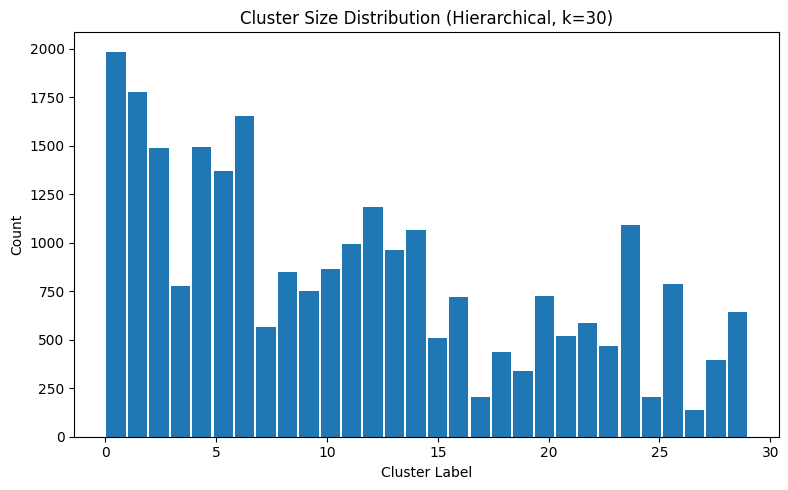

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(hier_labels, bins=best_k, rwidth=0.9)
plt.title(f'Cluster Size Distribution (Hierarchical, k={best_k})')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/hierarchical_cluster_histogram.png', dpi=300)
plt.show()


The cluster size histogram reveals substantial variation across the 30 clusters. Some groups contain over 1800 samples, whereas others contain only 200–400 samples. This imbalance is expected when applying hierarchical clustering to a complex image dataset, as some visual patterns appear more frequently than others. Larger clusters tend to represent broad or common feature categories, while smaller clusters likely correspond to more specialized or rare visual attributes. Despite the imbalance, the distribution shows that Ward linkage successfully partitions the dataset into meaningful subgroups with interpretable sizes.

## Dendogram - Ward linkage, Subeset of data

A full dendrogram for 20k+ points is not feasible, so we sample a smaller subset (e.g. 300–400 points) from the PCA space.

This dendrogram visualizes how clusters merge at different distances and illustrates the hierarchical structure of the dataset.

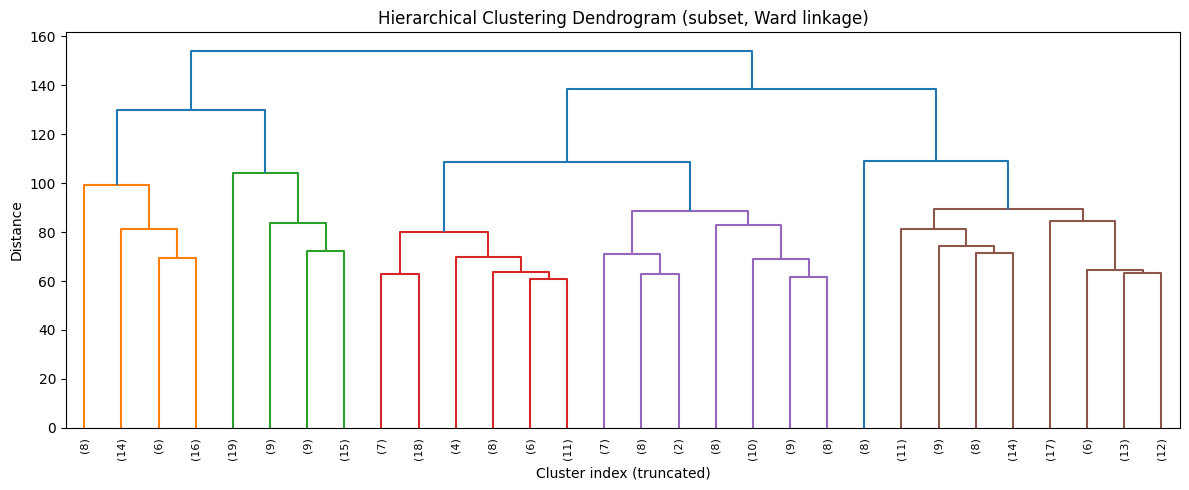

In [15]:
# Sample a subset for the dendrogram (300 random points)
np.random.seed(42)
subset_size = 300
indices = np.random.choice(len(X_pca_50), size=subset_size, replace=False)
X_subset = X_pca_50[indices]

# Compute linkage (Ward)
Z = linkage(X_subset, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=8.)
plt.title('Hierarchical Clustering Dendrogram (subset, Ward linkage)')
plt.xlabel('Cluster index (truncated)')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('images/hierarchical_dendrogram.png', dpi=300)
plt.show()


## Comparison with K-Means

In [21]:
# --- Compute K-Means metrics again for comparison ---

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Fit K-Means using the same PCA-reduced data and best_k = 30
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca_50)

# Compute K-Means metrics
kmeans_sil = silhouette_score(X_pca_50, kmeans_labels)
kmeans_db  = davies_bouldin_score(X_pca_50, kmeans_labels)
kmeans_ch  = calinski_harabasz_score(X_pca_50, kmeans_labels)

print("K-Means metrics:")
print("Silhouette:", kmeans_sil)
print("Davies–Bouldin:", kmeans_db)
print("Calinski–Harabasz:", kmeans_ch)


K-Means metrics:
Silhouette: 0.09111809
Davies–Bouldin: 2.5437486277485544
Calinski–Harabasz: 482.12964


In [26]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "K-Means (k=30)",
        "Agglomerative Ward (k=30)",
        "Agglomerative Complete (k=30)",
        "Agglomerative Average (k=30)"
    ],
    "Silhouette": [
        kmeans_sil,
        sil_ward,
        sil_complete,
        sil_average
    ],
    "Davies-Bouldin": [
        kmeans_db,
        db_ward,
        db_complete,
        db_average
    ],
    "Calinski-Harabasz": [
        kmeans_ch,
        ch_ward,
        ch_complete,
        ch_average
    ]
})

results


,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,K-Means (k=30),0.091118,2.543749,482.129639
1,Agglomerative Ward (k=30),0.054480,2.908700,382.222107
2,Agglomerative Complete (k=30),0.019236,3.030424,204.228134
3,Agglomerative Average (k=30),0.080356,1.451716,9.409791


Compared to the hierarchical methods, K-Means achieves the highest Silhouette score (0.091) and a strong Davies–Bouldin Index (2.54), showing that its clusters are both compact and relatively well separated. Ward linkage performs next best, producing more compact clusters than Average and Complete but remains slightly worse than K-Means in terms of Silhouette and DB. Complete linkage performs the worst across all metrics. Overall, K-Means remains the strongest clustering method for this dataset, while Ward provides the most meaningful hierarchical alternative.